## Importing modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import altair as alt
# import plotly.plotly as py
# import plotly.graph_objs as go
# import something else

In [2]:
from collections import defaultdict

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Getting data from TSV tables:

In [4]:
df_zebrafish = pd.read_csv("92759_Dataset_EV1/Dataset_EV1.txt", sep="\t")
df_human = pd.read_csv("92759_Dataset_EV2/Dataset_EV2.txt", sep="\t")
df_mouse = pd.read_csv("92759_Dataset_EV3/Dataset_EV3.txt", sep="\t")

In [5]:
sns.set_style("darkgrid")
sns.set_palette("deep")

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [7]:
def reset_axis():
    height, width = 6, 10
    sns.set(rc={"figure.figsize": (width, height)})
    return None

In [8]:
def change_fontsize(plot, size):
    for item in ([plot.title, plot.xaxis.label, plot.yaxis.label] +
                 plot.get_xticklabels() + plot.get_yticklabels()):
        item.set_fontsize(size)
    return None

In [9]:
def get_orf_type(row):
    if row["numuORFs"] > 0:
        return "u"
    elif row["numoORFs"] > 0:
        return "o"
    else:
        return "n"

In [10]:
orf_types = []
for df in [df_zebrafish, df_human, df_mouse]:
    orf_type_db = defaultdict(int)
    prev = [None, None]
    for _, row in df.iterrows():
        current_type = get_orf_type(row)
        
        if row["txID"] == prev[0]:
            if prev[1] == "u":
                pass
            elif prev[1] == "o" and current_type == "u":
                prev[1] = current_type
            elif prev[1] == "n":
                prev[1] = current_type
            else:
                pass
        else:
            orf_type_db[prev[1]] += 1
            prev[0] = row["txID"]
            prev[1] = current_type
            if prev[1]:
                orf_type_db[prev[1]] += 1
    orf_type_db[prev[1]] += 1
    orf_types.append(orf_type_db)

In [12]:
print(orf_types)

[defaultdict(<type 'int'>, {None: 1, 'u': 17314, 'o': 1938, 'n': 11492}), defaultdict(<type 'int'>, {None: 1, 'u': 13296, 'o': 2906, 'n': 22510}), defaultdict(<type 'int'>, {None: 1, 'u': 14422, 'o': 2846, 'n': 25150})]


## Pie charts

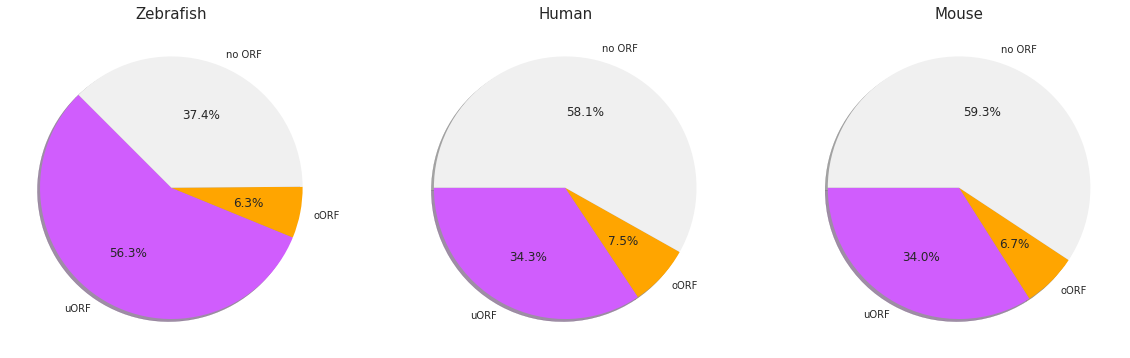

In [13]:
data = [{"values": [db["u"], db["o"], db["n"]],
         "labels": ["uORF", "oORF", "no ORF"]}
        for db in orf_types]
colors = ["#D05DFD", "orange", "#F0F0F0"]
sns.set(rc={"figure.figsize": (20, 6)})
fig = plt.figure()

plot1 = fig.add_subplot(1, 3, 1)
plot1.title.set_text("Zebrafish")
plot1.axis('equal')
plot1.pie(data[0]["values"], labels=data[0]["labels"], colors=colors, autopct='%1.1f%%', shadow=True, startangle=135)

plot2 = fig.add_subplot(1, 3, 2)
plot2.title.set_text("Human")
plot2.axis('equal')
plot2.pie(data[1]["values"], labels=data[1]["labels"], colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)

plot3 = fig.add_subplot(1, 3, 3)
plot3.title.set_text("Mouse")
plot3.axis('equal')
plot3.pie(data[2]["values"], labels=data[2]["labels"], colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)

for plot in [plot1, plot2, plot3]: change_fontsize(plot, 15)
reset_axis()

plt.savefig('3x1_pie.png')

## Many CDF charts

In [14]:
def get_df_type(df):
    df["ORFtype"] = [get_orf_type(row) for _, row in df.iterrows()]
for df in [df_zebrafish, df_human, df_mouse]: get_df_type(df)

In [15]:
(df_human["ORFtype"] == "u").head()

0    False
1    False
2    False
3    False
4    False
Name: ORFtype, dtype: bool

In [16]:
df_zero = df_zebrafish[(df_zebrafish["ORFtype"] == "n") & (df_zebrafish["orfFrame_GLOBAL"] > 6.044)]
df_fish_u = df_zebrafish[(df_zebrafish["ORFtype"] == "u")]
df_fish_o = df_zebrafish[(df_zebrafish["ORFtype"] == "o")]

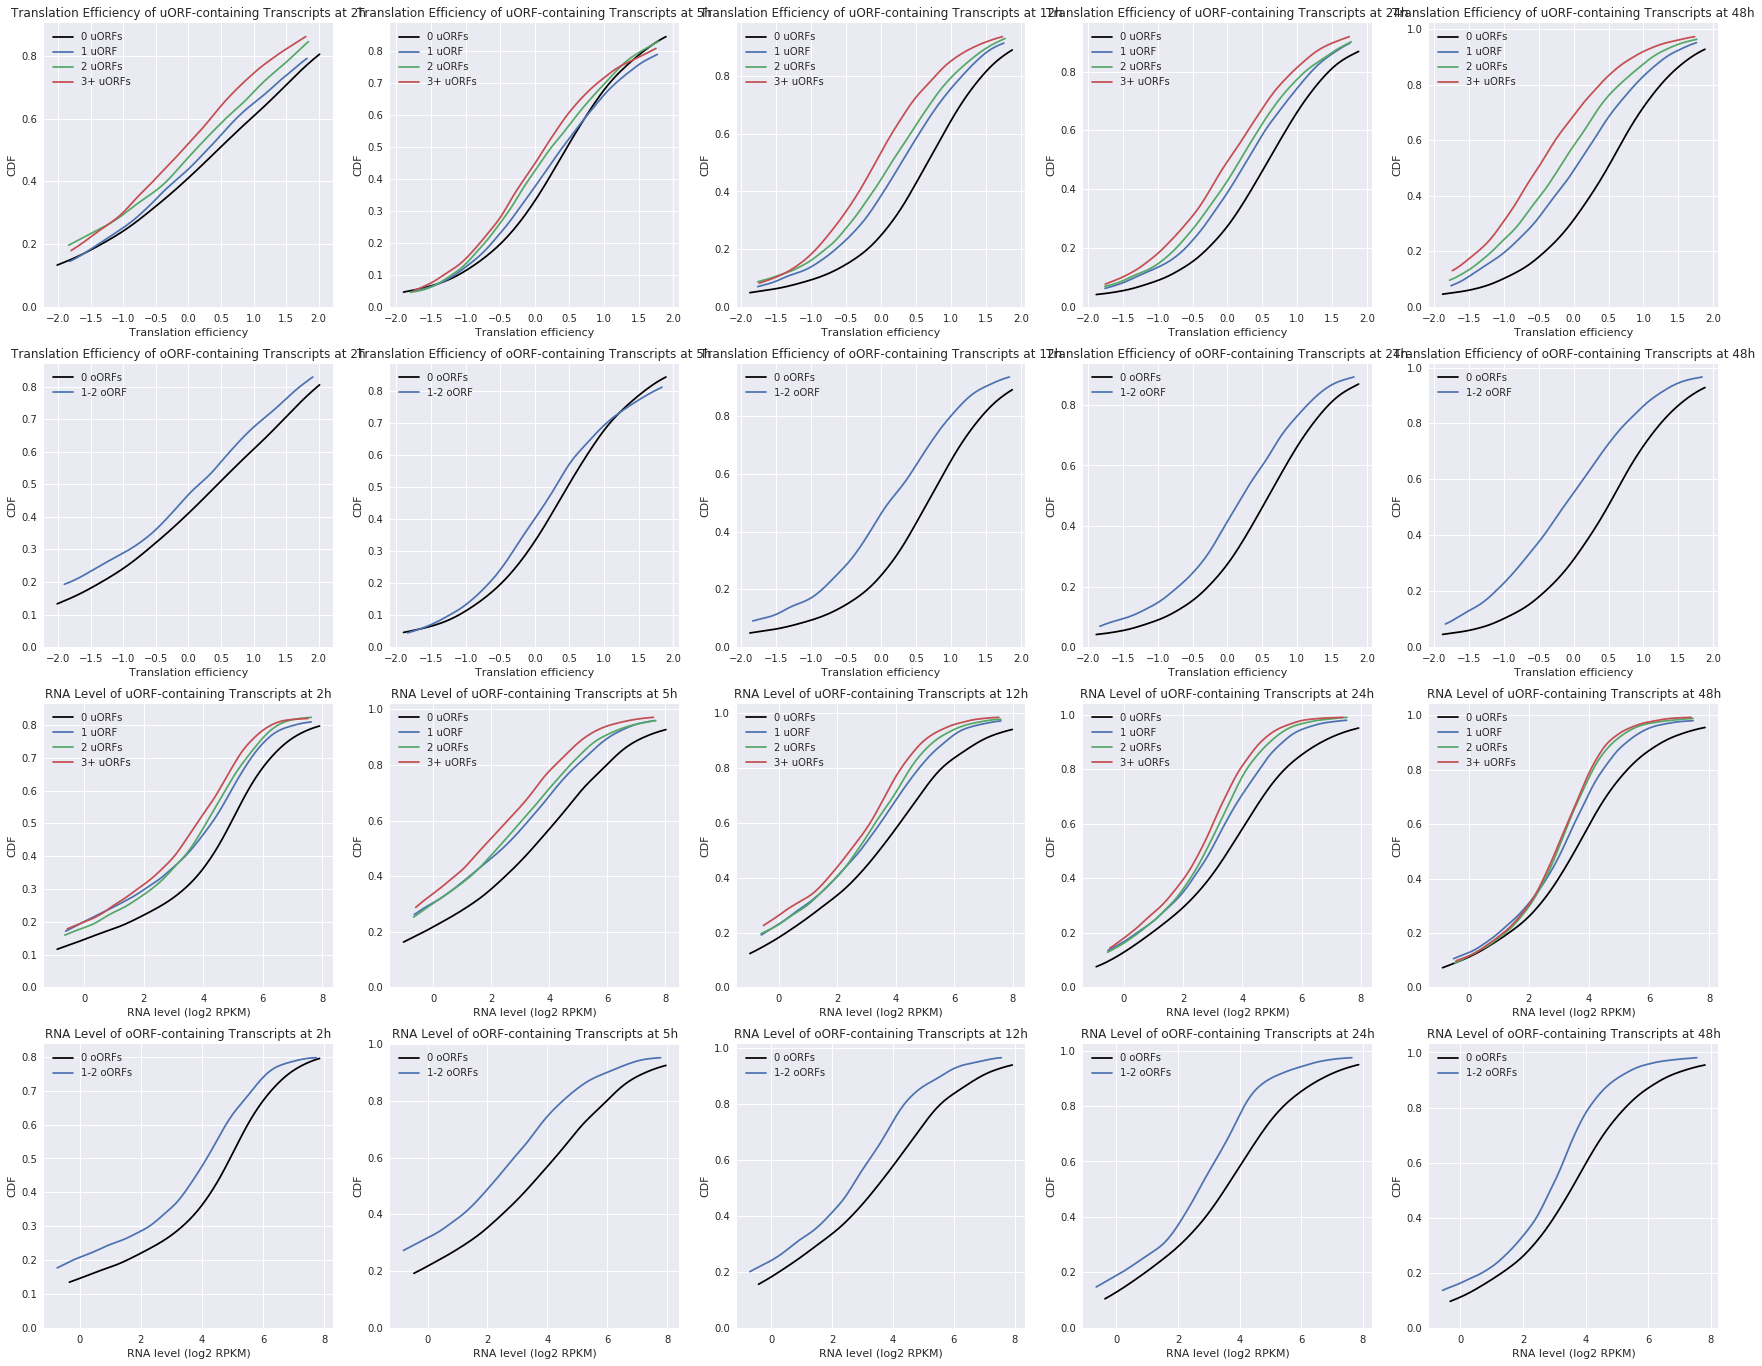

In [17]:
sns.set(rc={"figure.figsize": (30, 24)})
plt.figure()
hours = [2, 5, 12, 24, 48]
for i in range(5):
    plt.subplot(4, 5, 1 + i)
    sns.kdeplot(df_zero["CDSTE_{}h".format(hours[i])].dropna(), cumulative=True, clip=(-1.5, 1.5), color="black", label="0 uORFs")
    sns.kdeplot(df_fish_u[df_fish_u["numuORFs"] == 1]["CDSTE_{}h".format(hours[i])].dropna(), cumulative=True, clip=(-1.5, 1.5), label="1 uORF")
    sns.kdeplot(df_fish_u[df_fish_u["numuORFs"] == 2]["CDSTE_{}h".format(hours[i])].dropna(), cumulative=True, clip=(-1.5, 1.5), label="2 uORFs")
    sns.kdeplot(df_fish_u[df_fish_u["numuORFs"] >= 3]["CDSTE_{}h".format(hours[i])].dropna(), cumulative=True, clip=(-1.5, 1.5), label="3+ uORFs")
    plt.title("Translation Efficiency of uORF-containing Transcripts at {}h".format(hours[i]))
    plt.xlabel("Translation efficiency")
    plt.ylabel("CDF")

for i in range(5):
    plt.subplot(4, 5, 6 + i)
    sns.kdeplot(df_zero["CDSTE_{}h".format(hours[i])].dropna(), cumulative=True, clip=(-1.5, 1.5), color="black", label="0 oORFs")
    sns.kdeplot(df_fish_o[df_fish_o["numoORFs"] >= 1]["CDSTE_{}h".format(hours[i])].dropna(),
                cumulative=True, clip=(-1.5, 1.5), label="1-2 oORF")
    plt.title("Translation Efficiency of oORF-containing Transcripts at {}h".format(hours[i]))
    plt.xlabel("Translation efficiency")
    plt.ylabel("CDF")

for i in range(5):
    plt.subplot(4, 5, 11 + i)
    sns.kdeplot(np.log2(df_zero["tx_Input_RPKM_{}h".format(hours[i])].dropna()), cumulative=True, clip=(0, 7), color="black", label="0 uORFs")
    sns.kdeplot(np.log2(df_fish_u[df_fish_u["numuORFs"] == 1]["tx_Input_RPKM_{}h".format(hours[i])].dropna()), cumulative=True, clip=(0, 7), label="1 uORF")
    sns.kdeplot(np.log2(df_fish_u[df_fish_u["numuORFs"] == 2]["tx_Input_RPKM_{}h".format(hours[i])].dropna()), cumulative=True, clip=(0, 7), label="2 uORFs")
    sns.kdeplot(np.log2(df_fish_u[df_fish_u["numuORFs"] >= 3]["tx_Input_RPKM_{}h".format(hours[i])].dropna()), cumulative=True, clip=(0, 7), label="3+ uORFs")
    plt.title("RNA Level of uORF-containing Transcripts at {}h".format(hours[i]))
    plt.xlabel("RNA level (log2 RPKM)")
    plt.ylabel("CDF")

for i in range(5):
    plt.subplot(4, 5, 16 + i)
    sns.kdeplot(np.log2(df_zero["tx_Input_RPKM_{}h".format(hours[i])].dropna()), cumulative=True, clip=(0.5, 7), color="black", label="0 oORFs")
    sns.kdeplot(np.log2(df_fish_o[df_fish_o["numoORFs"] != 0]["tx_Input_RPKM_{}h".format(hours[i])].dropna()),
                cumulative=True, clip=(0, 7), label="1-2 oORFs")
    plt.title("RNA Level of oORF-containing Transcripts at {}h".format(hours[i]))
    plt.xlabel("RNA level (log2 RPKM)")
    plt.ylabel("CDF")

plt.savefig('4x5_CDF.png')

## More CDF charts

In [18]:
df_human_zero = df_human[df_human["ORFtype"] == "n"]
df_human_u = df_human[(df_human["ORFtype"] == "u")]
df_human_o = df_human[(df_human["ORFtype"] == "o")]

df_mouse_zero = df_mouse[df_mouse["ORFtype"] == "n"]
df_mouse_u = df_mouse[(df_mouse["ORFtype"] == "u")]
df_mouse_o = df_mouse[(df_mouse["ORFtype"] == "o")]

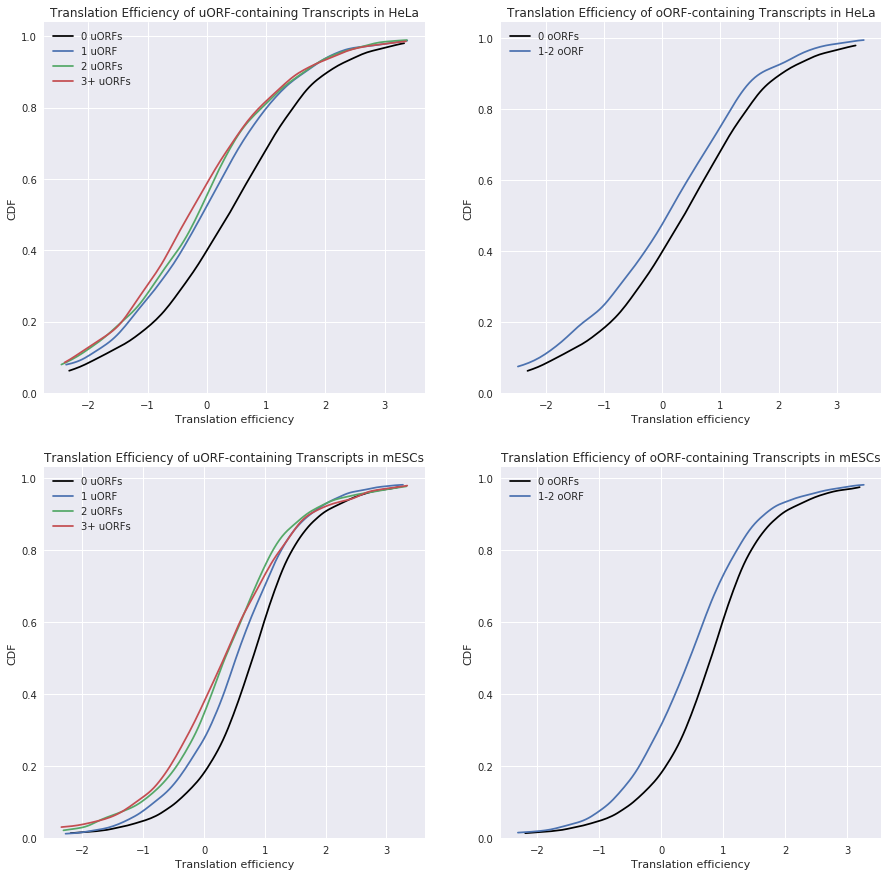

In [19]:
sns.set(rc={"figure.figsize": (15, 15)})
plt.figure()

plt.subplot(2, 2, 1)
sns.kdeplot(df_human_zero["CDSTE_hela"].dropna(), cumulative=True, clip=(-2, 3), color="black", label="0 uORFs")
sns.kdeplot(df_human_u[df_human_u["numuORFs"] == 1]["CDSTE_hela"].dropna(), cumulative=True, clip=(-2, 3), label="1 uORF")
sns.kdeplot(df_human_u[df_human_u["numuORFs"] == 2]["CDSTE_hela"].dropna(), cumulative=True, clip=(-2, 3), label="2 uORFs")
sns.kdeplot(df_human_u[df_human_u["numuORFs"] >= 3]["CDSTE_hela"].dropna(), cumulative=True, clip=(-2, 3), label="3+ uORFs")
plt.title("Translation Efficiency of uORF-containing Transcripts in HeLa")
plt.xlabel("Translation efficiency")
plt.ylabel("CDF")

plt.subplot(2, 2, 2)
sns.kdeplot(df_human_zero["CDSTE_hela"].dropna(), cumulative=True, clip=(-2, 3), color="black", label="0 oORFs")
sns.kdeplot(df_human_o[df_human_o["numoORFs"] >= 1]["CDSTE_hela"].dropna(),
            cumulative=True, clip=(-2, 3), label="1-2 oORF")
plt.title("Translation Efficiency of oORF-containing Transcripts in HeLa")
plt.xlabel("Translation efficiency")
plt.ylabel("CDF")

plt.subplot(2, 2, 3)
sns.kdeplot(df_mouse_zero["CDSTE_mescn"].dropna(), cumulative=True, clip=(-2, 3), color="black", label="0 uORFs")
sns.kdeplot(df_mouse_u[df_mouse_u["numuORFs"] == 1]["CDSTE_mescn"].dropna(), cumulative=True, clip=(-2, 3), label="1 uORF")
sns.kdeplot(df_mouse_u[df_mouse_u["numuORFs"] == 2]["CDSTE_mescn"].dropna(), cumulative=True, clip=(-2, 3), label="2 uORFs")
sns.kdeplot(df_mouse_u[df_mouse_u["numuORFs"] >= 3]["CDSTE_mescn"].dropna(), cumulative=True, clip=(-2, 3), label="3+ uORFs")
plt.title("Translation Efficiency of uORF-containing Transcripts in mESCs")
plt.xlabel("Translation efficiency")
plt.ylabel("CDF")

plt.subplot(2, 2, 4)
sns.kdeplot(df_mouse_zero["CDSTE_mescn"].dropna(), cumulative=True, clip=(-2, 3), color="black", label="0 oORFs")
sns.kdeplot(df_mouse_o[df_mouse_o["numoORFs"] >= 1]["CDSTE_mescn"].dropna(),
            cumulative=True, clip=(-2, 3), label="1-2 oORF")
plt.title("Translation Efficiency of oORF-containing Transcripts in mESCs")
plt.xlabel("Translation efficiency")
plt.ylabel("CDF")

plt.savefig('2x2_CDF.png')

## 2D charts

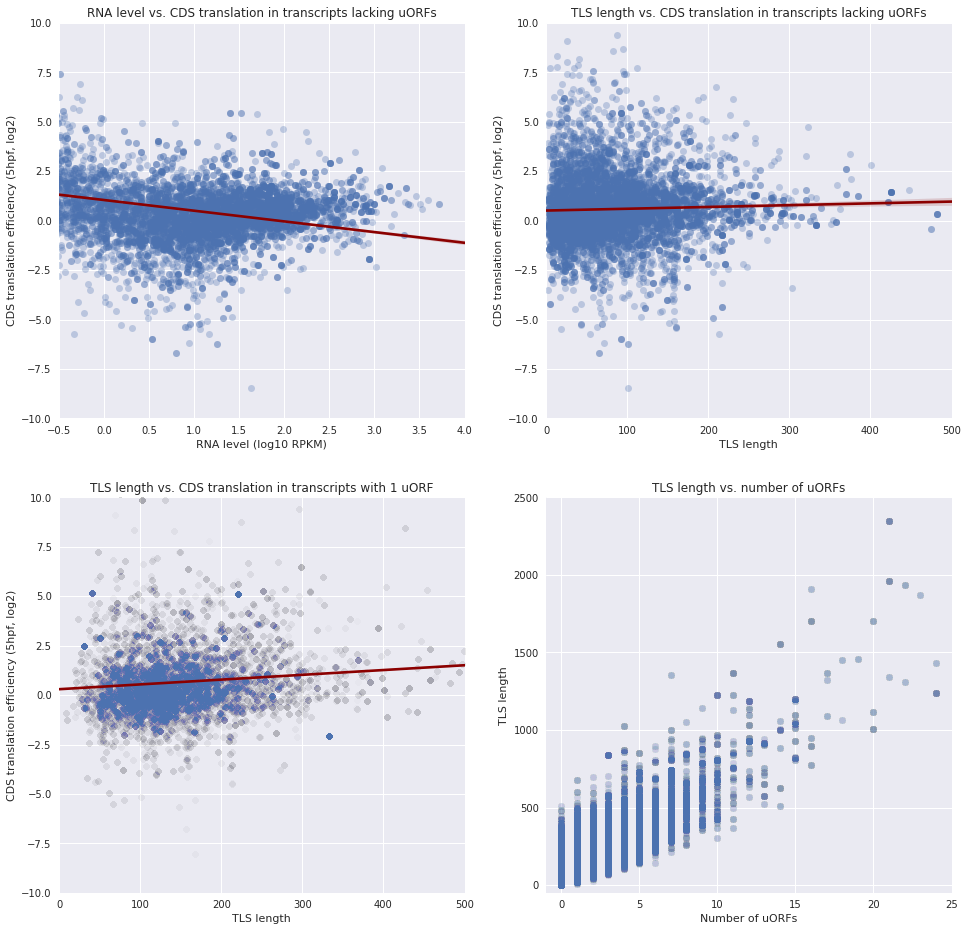

In [20]:
sns.set(rc={"figure.figsize": (16, 16)})
plt.figure()

plt.subplot(2, 2, 1)
sns.regplot(x=np.log10(df_zero["tx_Input_RPKM_5h"]), y=df_zero["CDSTE_5h"], scatter_kws={"alpha": 0.3}, line_kws={"color": "darkred"})
plt.title("RNA level vs. CDS translation in transcripts lacking uORFs")
plt.xlabel("RNA level (log10 RPKM)")
plt.ylabel("CDS translation efficiency (5hpf, log2)")
plt.axis((-0.5, 4, -10, 10))

plt.subplot(2, 2, 2)
sns.regplot(x=df_zero["txCDSStart"], y=df_zero["CDSTE_5h"], scatter_kws={"alpha": 0.3}, line_kws={"color": "darkred"})
plt.title("TLS length vs. CDS translation in transcripts lacking uORFs")
plt.xlabel("TLS length")
plt.ylabel("CDS translation efficiency (5hpf, log2)")
plt.axis((-0.5, 500, -10, 10))

df_one = df_fish_u[df_fish_u["numuORFs"] == 1]

plt.subplot(2, 2, 3)
sns.regplot(x=df_one["txCDSStart"], y=df_one["CDSTE_5h"], scatter_kws={"alpha": 0.005}, line_kws={"color": "darkred"})
plt.title("TLS length vs. CDS translation in transcripts with 1 uORF")
plt.xlabel("TLS length")
plt.ylabel("CDS translation efficiency (5hpf, log2)")
plt.axis((-0.5, 500, -10, 10))

plt.subplot(2, 2, 4)
sns.regplot(x=df_zebrafish["numuORFs"], y=df_zebrafish["txCDSStart"], fit_reg=False, scatter_kws={"alpha": 0.01})
plt.title("TLS length vs. number of uORFs")
plt.xlabel("Number of uORFs")
plt.ylabel("TLS length")
plt.axis((-1, 25, -50, 2500))

# plt.subplot(3, 2, 5)



plt.savefig('2x2_2D.png')

## Correlation plot

In [82]:
mouse_tissues = ['mescn', 'mescy', 'mef', 'liver', 'mef2wt', 
                 'mef2ko', 'mef2torin', 'mef3cyt', 'mef3er', 'brainwt', 'braintumor']
zebrafish_tissues = ['2h', '5h', '12h', '24h', '48h']
human_tissues = ['hela', 'hek', 'hbrainwt', 'hbraintumor', 'bjf1', 'bjf2']
list(df_mouse)

['orfID',
 'geneID',
 'transcriptID',
 'txID',
 'startLoc',
 'stopLoc',
 'genomic_chr',
 'genomic_start',
 'genomic_stop',
 'genomic_strand',
 'txCDSStart',
 'txCDSEnd',
 'color',
 'orfSize_effective',
 'Source',
 'tx_Input_RPKM_eb',
 'tx_Input_RPKM_mescn',
 'tx_Input_RPKM_mescy',
 'tx_Input_RPKM_mef',
 'tx_Input_RPKM_liver',
 'tx_Input_RPKM_mef2wt',
 'tx_Input_RPKM_mef2ko',
 'tx_Input_RPKM_mef2torin',
 'tx_Input_RPKM_mef3cyt',
 'tx_Input_RPKM_mef3er',
 'tx_Input_RPKM_brainwt',
 'tx_Input_RPKM_braintumor',
 'rpf_RPKM_eb',
 'rpf_RPKM_mescn',
 'rpf_RPKM_mescy',
 'rpf_RPKM_mef',
 'rpf_RPKM_liver',
 'rpf_RPKM_mef2wt',
 'rpf_RPKM_mef2ko',
 'rpf_RPKM_mef2torin',
 'rpf_RPKM_mef3cyt',
 'rpf_RPKM_mef3er',
 'rpf_RPKM_brainwt',
 'rpf_RPKM_braintumor',
 'utr5_rpf_RPKM_eb',
 'utr5_rpf_RPKM_mescn',
 'utr5_rpf_RPKM_mescy',
 'utr5_rpf_RPKM_mef',
 'utr5_rpf_RPKM_liver',
 'utr5_rpf_RPKM_mef2wt',
 'utr5_rpf_RPKM_mef2ko',
 'utr5_rpf_RPKM_mef2torin',
 'utr5_rpf_RPKM_mef3cyt',
 'utr5_rpf_RPKM_mef3er',
 'utr

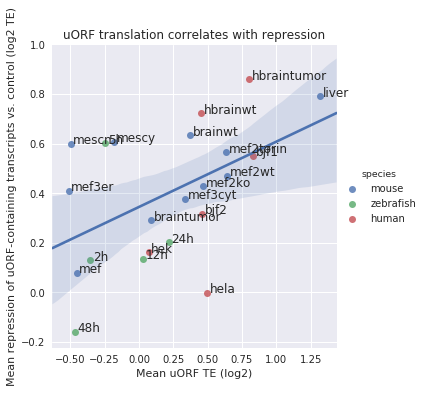

In [89]:
#orfTE
#CDSTE
def get_point(column, tissue, df):
    points = df['{}_{}'.format(column, tissue)].dropna().tolist()
    return sum(points)/len(points)

mouse_points = list(map(lambda x: (get_point('orfTE', x, df_mouse),
                                   get_point('CDSTE', x, df_mouse), 'mouse'), 
                        mouse_tissues))
zebrafish_points = list(map(lambda x: (get_point('orfTE', x, df_zebrafish),
                                   get_point('CDSTE', x, df_zebrafish), 'zebrafish'),
                            zebrafish_tissues))
human_points = list(map(lambda x: (get_point('orfTE', x, df_human),
                                   get_point('CDSTE', x, df_human), 'human'), 
                        human_tissues))
overall_points = mouse_points + zebrafish_points + human_points
data = {
    'name': mouse_tissues + zebrafish_tissues + human_tissues,
    'x': [x[0] for x in overall_points],
    'y': [x[1] for x in overall_points],
    'species': [x[2] for x in overall_points]
}

plot_df = pd.DataFrame(data)

g = sns.lmplot(x='x', y='y', hue='species', data=plot_df, fit_reg=False)
ax = sns.regplot(x='x', y='y', data=plot_df, scatter=False, ax=g.axes[0, 0])

plt.title('uORF translation correlates with repression')
plt.xlabel('Mean uORF TE (log2)')
plt.ylabel('Mean repression of uORF-containing transcripts vs. control (log2 TE)')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
label_point(plot_df.x, plot_df.y, plot_df.name, plt.gca())  
plt.savefig('correlation.png')